In [1]:
import os
import csv
from math import ceil

import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
from keras.models import Sequential, Model, load_model
from keras.layers import Cropping2D, Flatten, Dense, Convolution2D, Dropout, Lambda
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Add which test to read. Set whether to use the right and left image in each test.
# "use_sides": True -> if use left and right cameras for traning (only when recording in center position)
# "turning" -> direction of circulation
records = [
    {"name": "t1-center", "use_sides": True} ,
#     {"name": "t2-center", "use_sides": True} ,
    {"name": "t3-center-reverse", "use_sides": True} ,
#     {"name": "t4-center-reverse", "use_sides": True} ,
    {"name": "t8-recovery", "use_sides": True} ,
    {"name": "t9-hard-recovery", "use_sides": True} ,
    {"name": "t10-recovery-normal-lines", "use_sides": True} ,
    {"name": "data_udacity", "use_sides": True}
]

# Read CSVs
samples_array = [[],[]]
data_len = 0
for record in records:
    with open('./data/'+record["name"]+'/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            center_img = line[0]
            steering = float(line[3])
            samples_array[0].append(center_img)
            samples_array[1].append(steering)
            
            if record["use_sides"]:
                correction = 0.25
                steering_left = steering + correction
                steering_right = steering - correction
                    
                left_img = line[1]
                samples_array[0].append(left_img)
                samples_array[1].append(steering_left)
                
                right_img = line[2]
                samples_array[0].append(right_img)
                samples_array[1].append(steering_right)
                
    new_len = len(samples_array[0])-data_len
    data_len += new_len
    print("added "+str(new_len)+" dates from: "+record["name"])
        
samples_array = np.array(samples_array).T
print("total data = "+str(len(samples_array)))

added 4896 dates from: t1-center
added 6546 dates from: t3-center-reverse
added 3594 dates from: t8-recovery
added 1800 dates from: t9-hard-recovery
added 1983 dates from: t10-recovery-normal-lines
added 24108 dates from: data_udacity
total data = 42927


In [3]:
# test_img_route = './data/t5-center-hard-curves/IMG/center_2021_07_20_20_24_41_681.jpg'
# test_img = cv2.imread(test_img_route)
# crop_img = test_img[50:70, 0:1000]
# plt.imshow(crop_img)
# plt.show()

C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


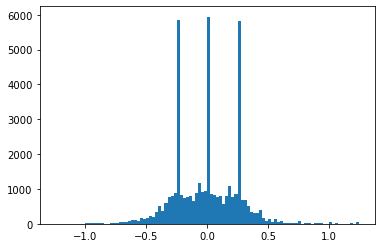

In [4]:
%matplotlib inline
steering = samples_array[:,1].astype(np.float)
n, bins, p = plt.hist(steering, bins=100)
plt.show()

In [5]:
# Crop high peaks of histogram
bins_cropped = 3

n = np.array(n)
crop_index = n.argsort()[-bins_cropped:]
crop_index = np.flip(crop_index)

remove_indx = []
for i in range(bins_cropped):
    indx_delete = crop_index[i]
    new_bean_values = (n[indx_delete+1]+n[indx_delete-1])/2 # mean of neighbors beans. This will be the new value of cropped bean
    nro_delete = np.int(n[crop_index[i]]-new_bean_values) # amount to delete
    
    indx = np.where((bins[indx_delete]<=steering) & (steering<bins[indx_delete+1]))
    indx = np.ravel(indx)
    np.random.shuffle(indx)
    remove_indx.extend(indx[0:nro_delete])

samples_array_balanced = []
for i , s in enumerate(samples_array):
    if i not in remove_indx:
        samples_array_balanced.append(s)

C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


C:\ProgramData\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


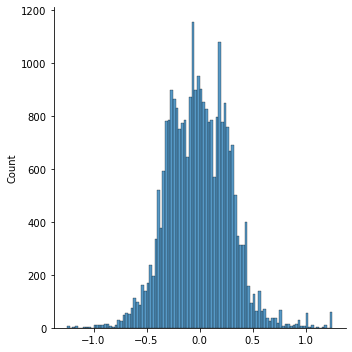

In [6]:
%matplotlib inline
steering = np.array(samples_array_balanced)[:,1].astype(np.float)
sns.displot(steering,bins=100)
plt.show()

#### Nvidia End to End Learning for Self-Driving Cars
Paper: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
<img src="nvidia-net.png" alt="NvidiaE2ENet" style="width: 400px;"/>

In [7]:
def get_model():
    ch, row, col = 3, 80, 320  # Trimmed image format
    ch, row, col = 3, 80, 320  # Trimmed image format

    # Model: Nvidia End to End Learning for Self-Driving Cars
    model = Sequential()
    
    # Preprocess incoming data, crop interest zone
    model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(160,320,3)))
    # Preprocess incoming data, centered around zero with small standard deviation 
    model.add(Lambda(lambda x: x/127.5 - 1.))

    model.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Dense(1))
    
    return model

In [8]:
# from keras import backend as K
# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# # Testing
# test_img_route = './data/t5-center-hard-curves/IMG/center_2021_07_20_20_24_41_681.jpg'
# test_img = cv2.imread(test_img_route)
# test_img = np.expand_dims(test_img, axis=0)
# print(test_img.shape)
# input_shape=(160,320,3)
# layer_outs = [func([test_img, 1.]) for func in functors]

# # Display normalized output
# a = np.array(layer_outs[1])[0][0]
# plt.imshow(a)
# plt.show()

In [9]:
def change_contrast(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    scale = np.random.uniform(.6, 1.2)
    hsv[:, :, 2] = hsv[:, :, 2] * scale
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def generator(samples_array, batch_size=32, traning_mode = False):
    num_samples = len(samples_array[0])
    while 1: # Loop forever so the generator never terminates
        shuffle(samples_array)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_array[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                file_name = batch_sample[0].split("\\")[-1]
                test_name = batch_sample[0].split("\\")[-3]
                name = './data/'+test_name+'/IMG/'+batch_sample[0].split("\\")[-1]
                img = cv2.imread(name)
                ang = float(batch_sample[1])
                
                # Generate random flipped images
                # Only for training (we should not augment validation data)
                if(traning_mode):
                    if np.random.rand() < 0.5:
                        img = np.fliplr(img)
                        ang = -ang
                    # Change contrast randomly
                    if np.random.rand() < 0.5:                    
                        img = change_contrast(img)
                
                images.append(img)
                angles.append(ang)

            # Trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


In [10]:
# Set our batch size
batch_size=256

# Split in train/validation
shuffle(samples_array_balanced)
train_samples, validation_samples = train_test_split(samples_array_balanced, test_size=0.3)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size, traning_mode  = True)
validation_generator = generator(validation_samples, batch_size=batch_size, traning_mode  = False)

model = get_model()

optimizer = optimizers.Adam(lr=0.0001)
model.compile(loss='mse', optimizer=optimizer)

# checkpoints_filepath="./checkpoints/weights-improvement-{epoch:02d}.hdf5"
checkpoints_filepath="./weights.best.hdf5"
checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0)
# callbacks_list = [checkpoint,es]
callbacks_list = [checkpoint]

history_object = model.fit_generator(train_generator,
            steps_per_epoch=ceil(len(train_samples)/batch_size),
            validation_data=validation_generator,
            validation_steps=ceil(len(validation_samples)/batch_size),
            epochs=100, callbacks=callbacks_list, verbose=1)

model.save('model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/100
118/118 [==============================] - 144s 1s/step - loss: 0.0434 - val_loss: 0.0358

Epoch 00001: val_loss improved from inf to 0.03575, saving model to ./weights.best.hdf5
Epoch 2/100
118/118 [==============================] - 143s 1s/step - loss: 0.0353 - val_loss: 0.0247

Epoch 00002: val_loss improved from 0.03575 to 0.02474, saving model to ./weights.best.hdf5
Epoch 3/100
118/118 [==============================] - 143s 1s/step - loss: 0.0332 - val_loss: 0.0287

Epoch 00003: val_loss did not improve from 0.02474
Epoch 4/100
118/118 [==============================] - 144s 1s/step - loss: 0.0317 - val_loss: 0.0243

Epoch 00004: val_loss improved from 0.02474 to 0.02428, saving model to ./weights.best.hdf5
Epoch 5/100
118/118 [==============================] - 143s 1s/step - loss: 0.0303 - val_loss: 0.0254

Epoch 00005: val_loss did not improve from 0.02428
Epoch 6/100
118/118 [========

118/118 [==============================] - 139s 1s/step - loss: 0.0127 - val_loss: 0.0140

Epoch 00047: val_loss did not improve from 0.01270
Epoch 48/100
118/118 [==============================] - 138s 1s/step - loss: 0.0128 - val_loss: 0.0176

Epoch 00048: val_loss did not improve from 0.01270
Epoch 49/100
118/118 [==============================] - 138s 1s/step - loss: 0.0126 - val_loss: 0.0139

Epoch 00049: val_loss did not improve from 0.01270
Epoch 50/100
118/118 [==============================] - 138s 1s/step - loss: 0.0122 - val_loss: 0.0215

Epoch 00050: val_loss did not improve from 0.01270
Epoch 51/100
118/118 [==============================] - 141s 1s/step - loss: 0.0124 - val_loss: 0.0173

Epoch 00051: val_loss did not improve from 0.01270
Epoch 52/100
118/118 [==============================] - 143s 1s/step - loss: 0.0124 - val_loss: 0.0136

Epoch 00052: val_loss did not improve from 0.01270
Epoch 53/100
118/118 [==============================] - 144s 1s/step - loss: 0.0119

KeyboardInterrupt: 

In [ ]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## Load and continue training

In [ ]:
# # Set our batch size
# batch_size=256

# # Split in train/validation
# shuffle(samples_array_balanced)
# train_samples, validation_samples = train_test_split(samples_array_balanced, test_size=0.3)

# model = load_model('./model.h5')

# optimizer = optimizers.Adam(lr=0.0001)
# model.compile(loss='mse', optimizer=optimizer)

# checkpoints_filepath="./weights_retrained.best.hdf5"
# checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='val_loss', 
#                              verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]

# history_object = model.fit_generator(train_generator,
#             steps_per_epoch=ceil(len(train_samples)/batch_size),
#             validation_data=validation_generator,
#             validation_steps=ceil(len(validation_samples)/batch_size),
#             epochs=20, callbacks=callbacks_list, verbose=1)

# model.save('model_retrained.h5')

In [ ]:
# def balance_data(samples, visulization_flag ,N=60, K=1,  bins=100):
#     """ Crop the top part of the steering angle histogram, by removing some images belong to those steering angels

#     :param images: images arrays
#     :param angles: angles arrays which
#     :param n:  The values of the histogram bins
#     :param bins: The edges of the bins. Length nbins + 1
#     :param K: maximum number of max bins to be cropped
#     :param N: the max number of the images which will be used for the bin
#     :return: images, angle
#     """

#     angles = samples[:,1].astype(np.float)
#     n, bins, patches = plt.hist(angles, bins=bins, color= 'orange', linewidth=0.1)
#     angles = np.array(angles)
#     n = np.array(n)

#     idx = n.argsort()[-K:][::-1]    # find the largest K bins
#     del_ind = []                    # collect the index which will be removed from the data
#     for i in range(K):
#         if n[idx[i]] > N:
#             ind = np.where((bins[idx[i]]<=angles) & (angles<bins[idx[i]+1]))
#             ind = np.ravel(ind)
#             np.random.shuffle(ind)
#             del_ind.extend(ind[:len(ind)-N])

#     # angles = np.delete(angles,del_ind)
#     balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]
#     balanced_angles = np.delete(angles,del_ind)

#     plt.subplot(1,2,2)
#     plt.hist(balanced_angles, bins=bins, color= 'orange', linewidth=0.1)
#     plt.title('modified histogram', fontsize=20)
#     plt.xlabel('steering angle', fontsize=20)
#     plt.ylabel('counts', fontsize=20)

#     if visulization_flag:
#         plt.figure
#         plt.subplot(1,2,1)
#         n, bins, patches = plt.hist(angles, bins=bins, color='orange', linewidth=0.1)
#         plt.title('origin histogram', fontsize=20)
#         plt.xlabel('steering angle', fontsize=20)
#         plt.ylabel('counts', fontsize=20)
#         plt.show()

#         plt.figure
#         aa = np.append(balanced_angles, -balanced_angles)
#         bb = np.append(aa, aa)
#         plt.hist(bb, bins=bins, color='orange', linewidth=0.1)
#         plt.title('final histogram', fontsize=20)
#         plt.xlabel('steering angle', fontsize=20)
#         plt.ylabel('counts', fontsize=20)
#         plt.show()

#     return balanced_samples